
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [46]:

# TODO: load prices and returns from Week 1
aapl = yf.download("AAPL", start="2015-01-01", end="2024-01-01", auto_adjust=False)

[*********************100%***********************]  1 of 1 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [47]:

# TODO: construct features using only past data
price = aapl["Adj Close"]
log_price = np.log(price)

logret = log_price.diff().dropna()
r_t_1 = logret.shift(1)

roll_mean_20 = logret.rolling(20).mean()
roll_vol_20 = logret.rolling(20).std()
momentum_5 = log_price.diff(5)


## 4. Naive baselines


In [48]:

# TODO: zero predictor
zero_pred = pd.Series(0.0, index=logret.index)

In [49]:
# TODO: rolling mean predictor
rolling_mean = logret.rolling(20).mean()
mean_pred = rolling_mean.shift(1)
mean_pred = mean_pred.dropna()
y = logret.shift(-1)
y = y.loc[mean_pred.index]



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [50]:

# use LinearRegression from sklearn
common_index = (
    logret.index
    .intersection(r_t_1.index)
    .intersection(roll_mean_20.index)
    .intersection(roll_vol_20.index)
    .intersection(momentum_5.index)
    .intersection(y.dropna().index)
)

X = np.column_stack([
    logret.loc[common_index],
    r_t_1.loc[common_index],
    roll_mean_20.loc[common_index],
    roll_vol_20.loc[common_index],
    momentum_5.loc[common_index]
])

y = y.dropna()

ols = LinearRegression()
ols.fit(X, y)

y_pred_ols = ols.predict(X)

ridge = Ridge()
ridge.fit(X, y)

y_pred_ridge = ridge.predict(X)


## 6. Tree-based model (Random Forest) (optional)


In [51]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)



## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [52]:

# TODO: implement TimeSeriesSplit evaluation
ts = TimeSeriesSplit(n_splits=5)

ols_rmse = []
for train_idx, test_idx in ts.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ols = LinearRegression()
    ols.fit(X_train, y_train)

    y_pred = ols.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    ols_rmse.append(rmse)

In [53]:
ridge_rmse = []
for train_idx, test_idx in ts.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ridge = Ridge()
    ridge.fit(X_train, y_train)

    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    ridge_rmse.append(rmse)


## 8. Prediction accuracy


In [54]:

# TODO: compute RMSE for all models and compare them

y_eval = y.loc[common_index]
zero_pred = np.zeros(len(y_eval))
mean_pred = mean_pred.loc[common_index]

rmse_zero = np.sqrt(mean_squared_error(y_eval, zero_pred))
rmse_mean = np.sqrt(mean_squared_error(y_eval, mean_pred))
rmse_ols = np.sqrt(mean_squared_error(y_eval, y_pred_ols))
rmse_ridge = np.sqrt(mean_squared_error(y_eval, y_pred_ridge))

In [55]:
rmse_table = pd.Series({
    "Zero Predictor": rmse_zero,
    "Rolling Mean Predictor": rmse_mean,
    "OLS": rmse_ols,
    "Ridge": rmse_ridge
})

print(rmse_table)

Zero Predictor            0.018271
Rolling Mean Predictor    0.018547
OLS                       0.018187
Ridge                     0.018213
dtype: float64


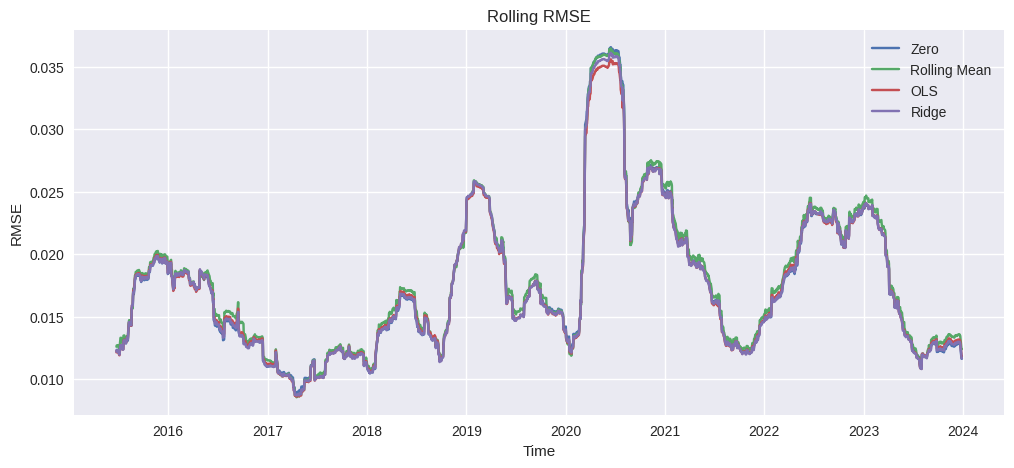

In [ ]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
def rolling_rmse(y, y_pred, window=100):
    err = (y - y_pred) ** 2
    return np.sqrt(err.rolling(window).mean())


zero_pred = pd.Series(0.0, index=common_index)
y_pred_ols_eval = pd.Series(y_pred_ols.ravel(), index=common_index)
y_pred_ridge_eval = pd.Series(y_pred_ridge.ravel(), index=common_index)

rmse_zero_roll = rolling_rmse(y_eval, zero_pred)
rmse_mean_roll = rolling_rmse(y_eval, mean_pred)
rmse_ols_roll = rolling_rmse(y_eval, y_pred_ols_eval)
rmse_ridge_roll = rolling_rmse(y_eval, y_pred_ridge_eval)

plt.figure(figsize=(12,5))


plt.plot(rmse_zero_roll, label="Zero")
plt.plot(rmse_mean_roll, label="Rolling Mean")
plt.plot(rmse_ols_roll, label="OLS")
plt.plot(rmse_ridge_roll, label="Ridge")

plt.title("Rolling RMSE")
plt.ylabel("RMSE")
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [ ]:
# TODO: compute the positions for each model and daily returns


In [ ]:
# TODO: plot your returns


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?